# Part 2

This notebook will answer all the questions in part 2

In [1]:
from datasets import load_dataset
from utils.rnn_model import *
from utils.rnn_utils import *
from utils.utils import *
from dotenv import load_dotenv
import os

load_dotenv()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Dataset Preparation 

First, we define all relevant hyperparameters, then we load the dataset.

After which, we will load the word embeddings and process the data accordingly

In [2]:
BATCH_SIZE = 32

In [3]:
dataset = load_dataset("rotten_tomatoes")
trn_dataset = dataset["train"]
val_dataset = dataset["validation"]
tst_dataset = dataset["test"]

### Word Embedding

We load the pre-trained Google News 300 dimension Word2Vec model and obtain a word index to be used later in data processing

In [4]:
sentences = trn_dataset["text"]
words = []

for i in range(len(sentences)):
    sentences[i] = simple_preprocess(sentences[i])

for sentence in sentences:
    for word in sentence:
        if word not in words:
            words.append(word)

In [5]:
word2vec_model = load_word2vec(vocab=words, filepath=r"data\embedding_matrix_oov.npy")

In [6]:
word_index = {
    word: i for i, word in enumerate(
        word2vec_model.index_to_key
    )
}

### Dataloaders

Once we have the dataset and the word index both loaded, we can proceed with building the dataloaders for batch training. We first prepare the data by tokenizing and padding the data so that they are all of the same length

In [7]:
trn_sentences, trn_labels = prepare_data(
    trn_dataset["text"],
    trn_dataset["label"],
    word_index=word_index
)
val_sentences, val_labels = prepare_data(
    val_dataset["text"],
    val_dataset["label"],
    word_index=word_index
)
tst_sentences, tst_labels = prepare_data(
    tst_dataset["text"],
    tst_dataset["label"],
    word_index=word_index
)

Once the data is processed, we create dataloaders for the data for batch training

In [8]:
trn_dataloader = create_dataloader(
    trn_sentences,
    trn_labels,
    BATCH_SIZE,
    shuffle=True)
val_dataloader = create_dataloader(
    val_sentences,
    val_labels,
    BATCH_SIZE,
    shuffle=False)
tst_dataloader = create_dataloader(
    tst_sentences,
    tst_labels,
    BATCH_SIZE,
    shuffle=False)

## Model

Once again, we define all relevant hyperparameters

In [9]:
LR = 0.0001
MODEL_TYPE = "rnn"

### 1. Default RNN

We initialise the model for the default RNN without any extra processing to derive the final sentence representation

In [10]:
model = RNNModel(
    embedding_dim=300,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,
    bidirectional=False,
    num_layers=1,
)

Now that all the data is loaded and processed into Dataloaders, we can start training!

In [11]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="1",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode=None
)

Epoch   1/100, Loss: 0.6966, Accuracy: 0.4981
Model saved.
Epoch   2/100, Loss: 0.6908, Accuracy: 0.5028
Model saved.
Epoch   3/100, Loss: 0.6797, Accuracy: 0.5403
Model saved.
Epoch   4/100, Loss: 0.6642, Accuracy: 0.5413
Model saved.
Epoch   5/100, Loss: 0.6462, Accuracy: 0.5769
Model saved.
Epoch   6/100, Loss: 0.6340, Accuracy: 0.5732
Epoch   7/100, Loss: 0.6217, Accuracy: 0.5591
Epoch   8/100, Loss: 0.6057, Accuracy: 0.5553
Epoch   9/100, Loss: 0.5925, Accuracy: 0.5553
Epoch  10/100, Loss: 0.5802, Accuracy: 0.5657
Epoch  11/100, Loss: 0.5657, Accuracy: 0.5694
Epoch  12/100, Loss: 0.5547, Accuracy: 0.5619
Epoch  13/100, Loss: 0.5381, Accuracy: 0.5675
Epoch  14/100, Loss: 0.5286, Accuracy: 0.5779
Model saved.
Epoch  15/100, Loss: 0.5155, Accuracy: 0.5507
Epoch  16/100, Loss: 0.5026, Accuracy: 0.5572
Epoch  17/100, Loss: 0.4924, Accuracy: 0.5685
Epoch  18/100, Loss: 0.4789, Accuracy: 0.5629
Epoch  19/100, Loss: 0.4694, Accuracy: 0.5657
Epoch  20/100, Loss: 0.4548, Accuracy: 0.5582
Ep

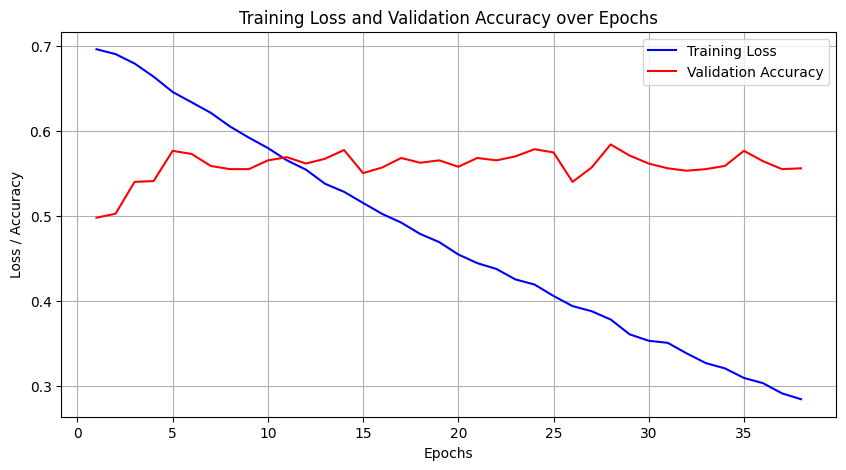

In [12]:
plot_loss_accuracy(losses, accuracies)

We run the validation check again to make sure we've loaded the right model

In [13]:
rnn_val_accuracy = validate(model, val_dataloader)

Accuracy: 0.5844


Test the model on the test set to obtain the accuracy

In [14]:
rnn_tst_accuracy = validate(model, tst_dataloader)

Accuracy: 0.5704


### 2. Last State RNN

This RNN will pick the hidden vector from the last time step as the sentence representation. This approach assumes that the last hidden state will capture the overall meaning of the sentence

In [15]:
model = RNNModel(
    embedding_dim=300,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,
    bidirectional=False,
    num_layers=1,
)

Now that all the data is loaded and processed into Dataloaders, we can start training!

In [16]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="1",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="last_state" # train only the last state
)

Epoch   1/100, Loss: 0.6952, Accuracy: 0.4897
Model saved.
Epoch   2/100, Loss: 0.6887, Accuracy: 0.5497
Model saved.
Epoch   3/100, Loss: 0.6733, Accuracy: 0.5582
Model saved.
Epoch   4/100, Loss: 0.6553, Accuracy: 0.5788
Model saved.
Epoch   5/100, Loss: 0.6413, Accuracy: 0.5891
Model saved.
Epoch   6/100, Loss: 0.6331, Accuracy: 0.5722
Epoch   7/100, Loss: 0.6190, Accuracy: 0.5760
Epoch   8/100, Loss: 0.6091, Accuracy: 0.5797
Epoch   9/100, Loss: 0.5946, Accuracy: 0.5919
Model saved.
Epoch  10/100, Loss: 0.5829, Accuracy: 0.5779
Epoch  11/100, Loss: 0.5721, Accuracy: 0.5797
Epoch  12/100, Loss: 0.5635, Accuracy: 0.5704
Epoch  13/100, Loss: 0.5508, Accuracy: 0.5722
Epoch  14/100, Loss: 0.5378, Accuracy: 0.5638
Epoch  15/100, Loss: 0.5284, Accuracy: 0.5722
Epoch  16/100, Loss: 0.5118, Accuracy: 0.5750
Epoch  17/100, Loss: 0.5037, Accuracy: 0.5741
Epoch  18/100, Loss: 0.4908, Accuracy: 0.5647
Epoch  19/100, Loss: 0.4810, Accuracy: 0.5704
Early stopping triggered after 19 epochs.
Traini

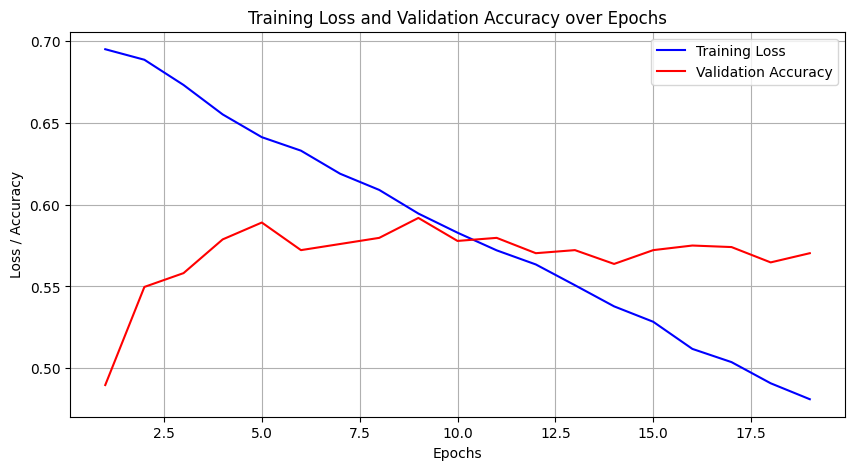

In [17]:
plot_loss_accuracy(losses, accuracies)

We run the validation check again to make sure we've loaded the right model

In [18]:
last_val_accuracy = validate(model, val_dataloader)

Accuracy: 0.5919


Test the model on the test set to obtain the accuracy

In [19]:
last_tst_accuracy = validate(model, tst_dataloader)

Accuracy: 0.6107


### 3. Mean Pooling RNN

This RNN will use the average of all hidden vectors as the sentence representation. This captures information across the whole sentence by averaging the all the words' contributions

In [20]:
model = RNNModel(
    embedding_dim=300,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,
    bidirectional=False,
    num_layers=1,
)

Now that all the data is loaded and processed into Dataloaders, we can start training!

In [21]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="1",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="mean_pool" # train only the mean pool
)

Epoch   1/100, Loss: 0.6959, Accuracy: 0.4869
Model saved.
Epoch   2/100, Loss: 0.6874, Accuracy: 0.5263
Model saved.
Epoch   3/100, Loss: 0.6735, Accuracy: 0.5600
Model saved.
Epoch   4/100, Loss: 0.6568, Accuracy: 0.5844
Model saved.
Epoch   5/100, Loss: 0.6429, Accuracy: 0.5675
Epoch   6/100, Loss: 0.6311, Accuracy: 0.5891
Model saved.
Epoch   7/100, Loss: 0.6203, Accuracy: 0.5685
Epoch   8/100, Loss: 0.6080, Accuracy: 0.5938
Model saved.
Epoch   9/100, Loss: 0.5977, Accuracy: 0.5750
Epoch  10/100, Loss: 0.5863, Accuracy: 0.5619
Epoch  11/100, Loss: 0.5713, Accuracy: 0.5835
Epoch  12/100, Loss: 0.5593, Accuracy: 0.5713
Epoch  13/100, Loss: 0.5487, Accuracy: 0.5722
Epoch  14/100, Loss: 0.5328, Accuracy: 0.5732
Epoch  15/100, Loss: 0.5230, Accuracy: 0.5507
Epoch  16/100, Loss: 0.5099, Accuracy: 0.5535
Epoch  17/100, Loss: 0.5002, Accuracy: 0.5835
Epoch  18/100, Loss: 0.4854, Accuracy: 0.5694
Early stopping triggered after 18 epochs.
Training ended, loading best model...
Model loaded.


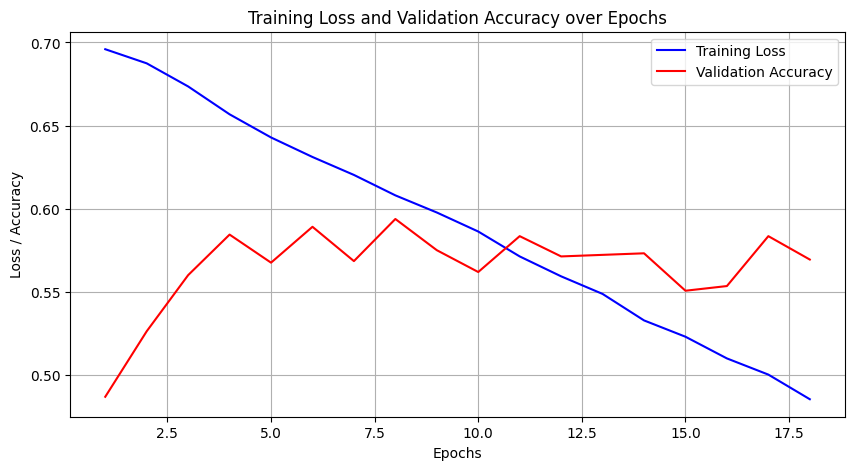

In [22]:
plot_loss_accuracy(losses, accuracies)

We run the validation check again to make sure we've loaded the right model

In [23]:
mean_val_accuracy = validate(model, val_dataloader)

Accuracy: 0.5938


Test the model on the test set to obtain the accuracy

In [24]:
mean_tst_accuracy = validate(model, tst_dataloader)

Accuracy: 0.5985


### 4. Max Pool RNN

This RNN will compute the max of all hidden vectors along each dimension. This will effectively use the most significant word as the representation of the sentence

In [25]:
model = RNNModel(
    embedding_dim=300,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,
    bidirectional=False,
    num_layers=1,
)

Now that all the data is loaded and processed into Dataloaders, we can start training!

In [26]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="1",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="max_pool" # train only the max pool
)

Epoch   1/100, Loss: 0.6969, Accuracy: 0.5028
Model saved.
Epoch   2/100, Loss: 0.6911, Accuracy: 0.5225
Model saved.
Epoch   3/100, Loss: 0.6803, Accuracy: 0.5403
Model saved.
Epoch   4/100, Loss: 0.6612, Accuracy: 0.5797
Model saved.
Epoch   5/100, Loss: 0.6449, Accuracy: 0.5901
Model saved.
Epoch   6/100, Loss: 0.6313, Accuracy: 0.5722
Epoch   7/100, Loss: 0.6193, Accuracy: 0.5779
Epoch   8/100, Loss: 0.6067, Accuracy: 0.5732
Epoch   9/100, Loss: 0.5881, Accuracy: 0.5713
Epoch  10/100, Loss: 0.5744, Accuracy: 0.5657
Epoch  11/100, Loss: 0.5646, Accuracy: 0.5675
Epoch  12/100, Loss: 0.5471, Accuracy: 0.5788
Epoch  13/100, Loss: 0.5335, Accuracy: 0.5666
Epoch  14/100, Loss: 0.5211, Accuracy: 0.5685
Epoch  15/100, Loss: 0.5125, Accuracy: 0.5450
Early stopping triggered after 15 epochs.
Training ended, loading best model...
Model loaded.


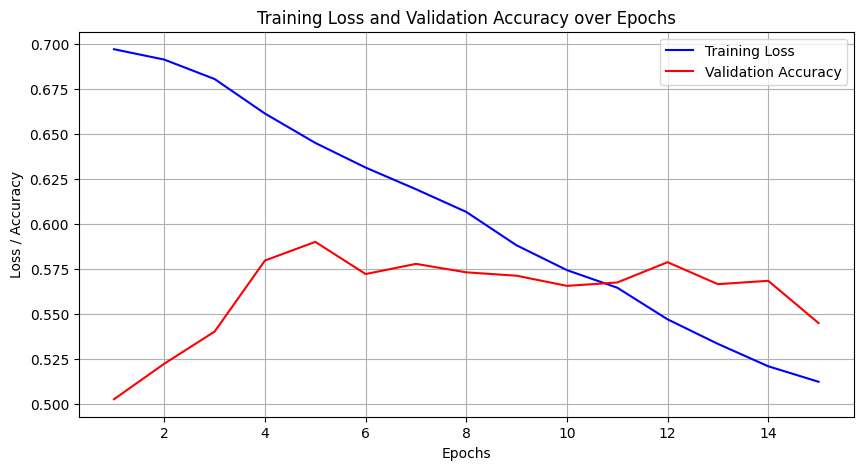

In [27]:
plot_loss_accuracy(losses, accuracies)

We run the validation check again to make sure we've loaded the right model

In [28]:
max_val_accuracy = validate(model, val_dataloader)

Accuracy: 0.5901


Test the model on the test set to obtain the accuracy

In [29]:
max_tst_accuracy = validate(model, tst_dataloader)

Accuracy: 0.5760


### 5. Mean and Max Pooled RNN

This RNN will compute the average of both the Mean pooled and Max pooled values. This should be able to smooth out the pros and cons of both Mean Pooling and Max Pooling

In [30]:
model = RNNModel(
    embedding_dim=300,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,
    bidirectional=False,
    num_layers=1,
)

Now that all the data is loaded and processed into Dataloaders, we can start training!

In [31]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="1",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="mean_max"
)

Epoch   1/100, Loss: 0.6972, Accuracy: 0.5066
Model saved.
Epoch   2/100, Loss: 0.6895, Accuracy: 0.5328
Model saved.
Epoch   3/100, Loss: 0.6764, Accuracy: 0.5657
Model saved.
Epoch   4/100, Loss: 0.6591, Accuracy: 0.5610
Epoch   5/100, Loss: 0.6442, Accuracy: 0.5610
Epoch   6/100, Loss: 0.6350, Accuracy: 0.5797
Model saved.
Epoch   7/100, Loss: 0.6249, Accuracy: 0.5750
Epoch   8/100, Loss: 0.6095, Accuracy: 0.5882
Model saved.
Epoch   9/100, Loss: 0.5993, Accuracy: 0.5685
Epoch  10/100, Loss: 0.5843, Accuracy: 0.5816
Epoch  11/100, Loss: 0.5710, Accuracy: 0.5629
Epoch  12/100, Loss: 0.5603, Accuracy: 0.5882
Epoch  13/100, Loss: 0.5493, Accuracy: 0.5863
Epoch  14/100, Loss: 0.5333, Accuracy: 0.5685
Epoch  15/100, Loss: 0.5216, Accuracy: 0.5901
Model saved.
Epoch  16/100, Loss: 0.5092, Accuracy: 0.5957
Model saved.
Epoch  17/100, Loss: 0.4944, Accuracy: 0.5769
Epoch  18/100, Loss: 0.4848, Accuracy: 0.5675
Epoch  19/100, Loss: 0.4718, Accuracy: 0.5854
Epoch  20/100, Loss: 0.4629, Accura

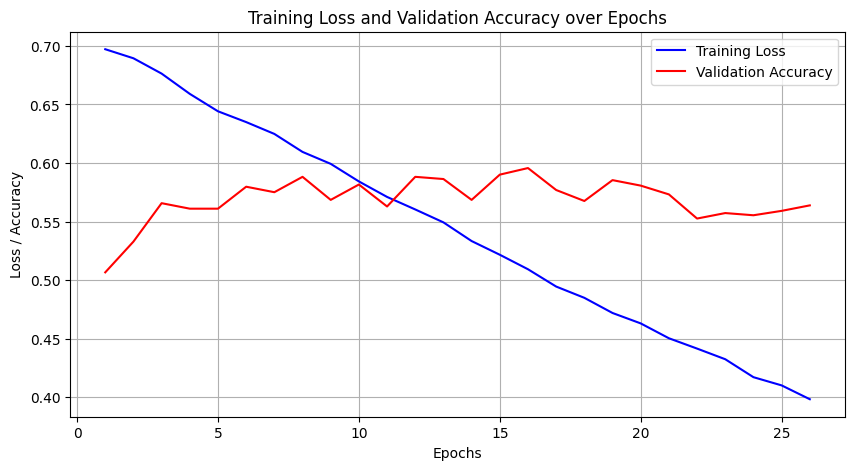

In [32]:
plot_loss_accuracy(losses, accuracies)

We run the validation check again to make sure we've loaded the right model

In [33]:
meanmax_val_accuracy = validate(model, val_dataloader)

Accuracy: 0.5957


Test the model on the test set to obtain the accuracy

In [34]:
meanmax_tst_accuracy = validate(model, tst_dataloader)

Accuracy: 0.6013


### 6. Attention RNN

This RNN applies an attention mask on the output vectors

In [35]:
model = RNNModel(
    embedding_dim=300,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,
    bidirectional=False,
    num_layers=1,
)

Now that all the data is loaded and processed into Dataloaders, we can start training!

In [36]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="1",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="attention"
)

Epoch   1/100, Loss: 0.6955, Accuracy: 0.4944
Model saved.
Epoch   2/100, Loss: 0.6883, Accuracy: 0.5019
Model saved.
Epoch   3/100, Loss: 0.6753, Accuracy: 0.5619
Model saved.
Epoch   4/100, Loss: 0.6604, Accuracy: 0.5685
Model saved.
Epoch   5/100, Loss: 0.6451, Accuracy: 0.5750
Model saved.
Epoch   6/100, Loss: 0.6329, Accuracy: 0.5826
Model saved.
Epoch   7/100, Loss: 0.6205, Accuracy: 0.5797
Epoch   8/100, Loss: 0.6085, Accuracy: 0.5797
Epoch   9/100, Loss: 0.5957, Accuracy: 0.5469
Epoch  10/100, Loss: 0.5819, Accuracy: 0.5544
Epoch  11/100, Loss: 0.5676, Accuracy: 0.5713
Epoch  12/100, Loss: 0.5551, Accuracy: 0.5685
Epoch  13/100, Loss: 0.5412, Accuracy: 0.5685
Epoch  14/100, Loss: 0.5264, Accuracy: 0.5638
Epoch  15/100, Loss: 0.5160, Accuracy: 0.5685
Epoch  16/100, Loss: 0.5046, Accuracy: 0.5760
Early stopping triggered after 16 epochs.
Training ended, loading best model...
Model loaded.


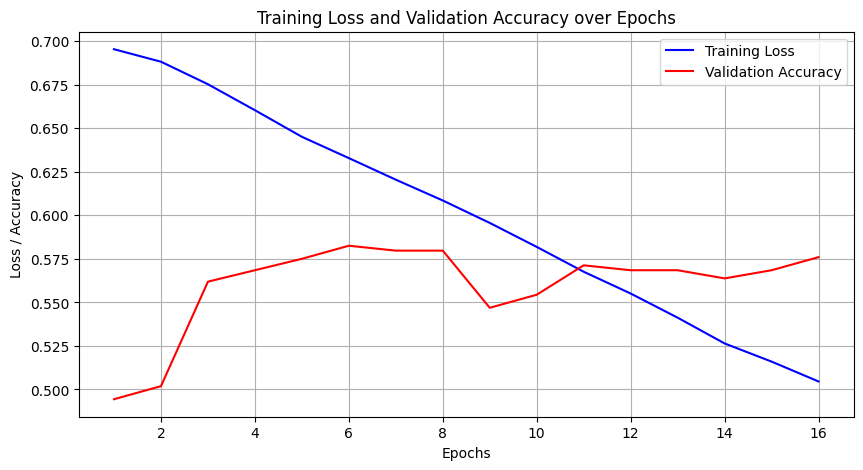

In [37]:
plot_loss_accuracy(losses, accuracies)

We run the validation check again to make sure we've loaded the right model

In [38]:
attn_val_accuracy = validate(model, val_dataloader)

Accuracy: 0.5826


Test the model on the test set to obtain the accuracy

In [39]:
attn_tst_accuracy = validate(model, tst_dataloader)

Accuracy: 0.5891


## Results

In [40]:
print(f"RNN Test Accuracy:              {rnn_tst_accuracy:.4f}")
print(f"Last State Test Accuracy:       {last_tst_accuracy:.4f}")
print(f"Mean Pool Test Accuracy:        {mean_tst_accuracy:.4f}")
print(f"Max Pool Test Accuracy:         {max_tst_accuracy:.4f}")
print(f"Mean Max Pool Test Accuracy:    {meanmax_tst_accuracy:.4f}")
print(f"Attention Test Accuracy:        {attn_tst_accuracy:.4f}")

RNN Test Accuracy:              0.5704
Last State Test Accuracy:       0.6107
Mean Pool Test Accuracy:        0.5985
Max Pool Test Accuracy:         0.5760
Mean Max Pool Test Accuracy:    0.6013
Attention Test Accuracy:        0.5891


Based on the test accuracies, the RNN that uses Last State has the highest test accuracy. However, it is worth noting that other models might have a better result if the word embeddings were trained.